# Causal Modeling and Simulation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

In [2]:
from dowhy import CausalModel
import statsmodels.formula.api as smf

## Data Generation
Simulation is a great way to test out causal modeling. Since we are not able to observe a counterfactual (what would have happened in a "different world"), simulation allows us to know the answer and test how close our model comes to this true effect.

In [3]:
num_samples = 100
df = pd.DataFrame({
    'id': np.arange(num_samples),
    'healthy_diet': np.random.randint(0, 2, size=num_samples),
    'smokes':  np.random.randint(0, 2, size=num_samples)
})
df['life_expectancy'] = 70.0 + df.healthy_diet*15.0 + df.smokes*-10.0 # Simulated effect

In [4]:
df.head(5)

,id,healthy_diet,smokes,life_expectancy
0,0,1,1,75.0
1,1,0,0,70.0
2,2,0,0,70.0
3,3,0,0,70.0
4,4,1,1,75.0


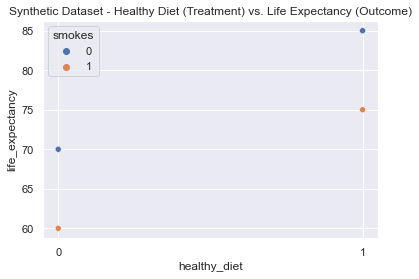

In [5]:
ax = sns.scatterplot(data=df, x='healthy_diet', y='life_expectancy', hue='smokes')
ax.set_title('Synthetic Dataset - Healthy Diet (Treatment) vs. Life Expectancy (Outcome)')
ax.set_xticks([0,1])

In [6]:
df.groupby(['healthy_diet', 'smokes']).size()

healthy_diet  smokes
0             0         23
              1         14
1             0         29
              1         34
dtype: int64

# Simple Difference

In [7]:
print(np.mean(df.loc[df.healthy_diet==1,'life_expectancy']) - np.mean(df.loc[df.healthy_diet==0,'life_expectancy']))

13.386958386958398


In [8]:
ols_result = smf.ols('life_expectancy ~ healthy_diet', data=df).fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     168.1
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           5.56e-23
Time:                        12:12:10   Log-Likelihood:                -301.53
No. Observations:                 100   AIC:                             607.1
Df Residuals:                      98   BIC:                             612.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       66.2162      0.820     80.797   

## Linear Regression with Controls

In [9]:
ols_result = smf.ols('life_expectancy ~ healthy_diet + smokes', data=df).fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.218e+30
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        12:12:10   Log-Likelihood:                 2948.2
No. Observations:                 100   AIC:                            -5890.
Df Residuals:                      97   BIC:                            -5882.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       70.0000      7e-15   9.99e+15   

## Causal Graph/Model
We can define the causal graph using the following notation. This can be helpful when integrating with the dowhy package.

In [10]:
causal_graph = """digraph{
    healthy_diet;
    smokes;
    life_expectancy;
    U[label="Unknown Confounders"];
    U -> healthy_diet;
    U -> smokes;
    healthy_diet -> life_expectancy;
    smokes -> life_expectancy;
}"""

In [11]:
model = CausalModel(
    data=df,
    graph=causal_graph.replace("\n", " "),
    treatment='healthy_diet',
    outcome='life_expectancy'
)

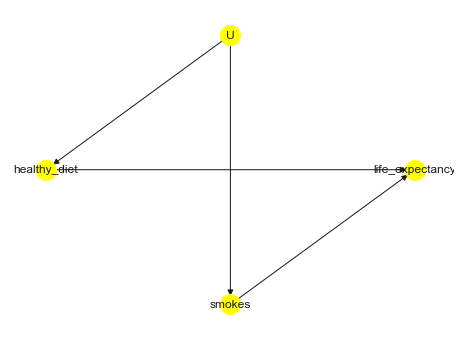

In [12]:
model.view_model()

In [13]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                  
───────────────(E[life_expectancy|smokes])
d[healthy_diet]                           
Estimand assumption 1, Unconfoundedness: If U→{healthy_diet} and U→life_expectancy then P(life_expectancy|healthy_diet,smokes,U) = P(life_expectancy|healthy_diet,smokes)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [14]:
estimate = model.estimate_effect(identified_estimand, method_name='backdoor.linear_regression')
print(estimate)

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['smokes']}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                  
───────────────(E[life_expectancy|smokes])
d[healthy_diet]                           
Estimand assumption 1, Unconfoundedness: If U→{healthy_diet} and U→life_expectancy then P(life_expectancy|healthy_diet,smokes,U) = P(life_expectancy|healthy_diet,smokes)

## Realized estimand
b: life_expectancy~healthy_diet+smokes+healthy_diet*smokes
Target units: ate

## Estimate
Mean value: 15.000000000000028
### Conditional Estimates
__categorical__smokes
(-0.001, 1.0]    15.0
dtype: float64


In [15]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['smokes']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['smokes']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['smokes']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['smokes']}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['smokes']}
{'control_value': 0, 'treatment_value': 